# Saved data preview

In [9]:
data_folder='../data/'

## 1. Preview the data

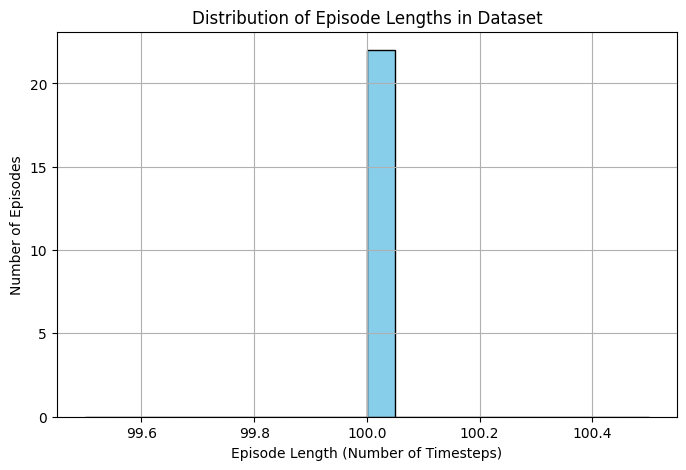

Number of episodes: 22
Min length: 100
Max length: 100
Mean length: 100.00
Median length: 100
Files with shortest episodes:
  episode_36.hdf5: 100
  episode_37.hdf5: 100
  episode_38.hdf5: 100
Files with longest episodes:
  episode_36.hdf5: 100
  episode_37.hdf5: 100
  episode_38.hdf5: 100

Data shape information for each data type:
  action:
    shape (100, 14): 22 episodes
    --> All episodes have the same shape for 'action'.
  qpos:
    shape (100, 14): 22 episodes
    --> All episodes have the same shape for 'qpos'.
  qvel:
    shape (100, 14): 22 episodes
    --> All episodes have the same shape for 'qvel'.


In [22]:
# Plot the distribution of episode lengths (time steps) in the hdf5 files

import h5py
import os
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

episode_lengths = []
episode_files = []

# To store shapes for each data type
data_shapes = defaultdict(list)  # {data_type: [shape, ...]}
data_types = set()

for file in os.listdir(data_folder):
    if file.endswith('.hdf5'):
        file_path = os.path.join(data_folder, file)
        with h5py.File(file_path, 'r') as f:
            # Assume 'qpos' is a time series: first dimension is episode length
            length = f['observations']['qpos'].shape[0]
            episode_lengths.append(length)
            episode_files.append(file)
            # Collect shapes for all datasets under 'observations'
            obs_group = f['observations']
            for key in obs_group.keys():
                if isinstance(obs_group[key], h5py.Dataset):
                    shape = obs_group[key].shape
                    data_shapes[key].append(shape)
                    data_types.add(key)
            # Also check for top-level datasets (e.g., 'action')
            for key in f.keys():
                if isinstance(f[key], h5py.Dataset):
                    shape = f[key].shape
                    data_shapes[key].append(shape)
                    data_types.add(key)
                elif isinstance(f[key], h5py.Group):
                    # Already handled 'observations' above
                    continue

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(episode_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Episode Length (Number of Timesteps)')
plt.ylabel('Number of Episodes')
plt.title('Distribution of Episode Lengths in Dataset')
plt.grid(True)
plt.show()

# Optionally, print some stats
print(f"Number of episodes: {len(episode_lengths)}")
if episode_lengths:
    print(f"Min length: {min(episode_lengths)}")
    print(f"Max length: {max(episode_lengths)}")
    print(f"Mean length: {sum(episode_lengths)/len(episode_lengths):.2f}")
    print(f"Median length: {sorted(episode_lengths)[len(episode_lengths)//2]}")
    # Optionally, print outliers or file names for very short/long episodes
    print("Files with shortest episodes:")
    for f, l in sorted(zip(episode_files, episode_lengths), key=lambda x: x[1])[:3]:
        print(f"  {f}: {l}")
    print("Files with longest episodes:")
    for f, l in sorted(zip(episode_files, episode_lengths), key=lambda x: -x[1])[:3]:
        print(f"  {f}: {l}")

# Print data shape info for each data type
print("\nData shape information for each data type:")
for dtype in sorted(data_types):
    shapes = data_shapes[dtype]
    shape_counts = Counter(shapes)
    print(f"  {dtype}:")
    for shape, count in shape_counts.items():
        print(f"    shape {shape}: {count} episodes")
    if len(shape_counts) == 1:
        print(f"    --> All episodes have the same shape for '{dtype}'.")
    else:
        print(f"    --> WARNING: Not all episodes have the same shape for '{dtype}'.")


In [18]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

def review_episode_sample(hdf5_name=None, data_folder='../data'):
    """
    Review and visualize a sample episode from the dataset.
    If hdf5_name is provided, show info for that file.
    If hdf5_name is None, pick a random episode from all .hdf5 files in data_folder.
    """
    import random

    # List all .hdf5 files in the data_folder
    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    episode_files = [f for f in os.listdir(data_folder) if f.endswith('.hdf5')]
    if not episode_files:
        print("No episode files found to review.")
        return

    # Determine which file to review
    if hdf5_name is not None:
        if hdf5_name in episode_files:
            sample_file = hdf5_name
        else:
            print(f"Provided hdf5_name '{hdf5_name}' not found in '{data_folder}'.")
            return
    else:
        sample_file = random.choice(episode_files)

    sample_path = os.path.join(data_folder, sample_file)
    print(f"\nReviewing sample episode: {sample_file}")

    with h5py.File(sample_path, 'r') as f:
        # List available datasets/groups
        print("Available datasets/groups in this file:")
        def print_tree(name, obj):
            print("  " + name)
        f.visititems(print_tree)

        # Plot a sequence (e.g., qpos, qvel, action)
        obs = f['observations']
        qpos = obs['qpos'][:]
        print(f"qpos shape: {qpos.shape}")
        plt.figure(figsize=(12, 4))
        for i in range(min(qpos.shape[1], 7)):  # Plot up to 7 joints
            plt.plot(qpos[:, i], label=f'qpos[{i}]')
        plt.title('qpos (first 7 joints) over time')
        plt.xlabel('Timestep')
        plt.ylabel('qpos value')
        plt.legend()
        plt.show()

        # Plot qvel if available
        if 'qvel' in obs:
            qvel = obs['qvel'][:]
            print(f"qvel shape: {qvel.shape}")
            plt.figure(figsize=(12, 4))
            for i in range(min(qvel.shape[1], 7)):  # Plot up to 7 joints
                plt.plot(qvel[:, i], label=f'qvel[{i}]')
            plt.title('qvel (first 7 joints) over time')
            plt.xlabel('Timestep')
            plt.ylabel('qvel value')
            plt.legend()
            plt.show()
        else:
            print("No 'qvel' dataset found in 'observations'.")

        # If available, plot action
        if 'action' in f:
            action = f['action'][:]
            print(f"action shape: {action.shape}")
            plt.figure(figsize=(12, 4))
            for i in range(min(action.shape[1], 7)):
                plt.plot(action[:, i], label=f'action[{i}]')
            plt.title('action (first 7 dims) over time')
            plt.xlabel('Timestep')
            plt.ylabel('action value')
            plt.legend()
            plt.show()

        # Show some image samples if present
        if 'images' in obs:
            image_group = obs['images']
            cam_names = list(image_group.keys())
            if cam_names:
                # Plot for all cameras, including wrist_cam_left and wrist_cam_right if present
                for cam in cam_names:
                    imgs = image_group[cam]
                    print(f"Image dataset '{cam}' shape: {imgs.shape}")
                    # Show first, middle, last frame
                    idxs = [0, len(imgs)//2, len(imgs)-1] if len(imgs) > 2 else list(range(len(imgs)))
                    plt.figure(figsize=(15, 5))
                    for i, idx in enumerate(idxs):
                        plt.subplot(1, len(idxs), i+1)
                        img = imgs[idx]
                        plt.imshow(img)
                        plt.title(f"{cam} frame {idx}")
                        plt.axis('off')
                    plt.suptitle(f"Sample images from '{cam}' in episode '{sample_file}'")
                    plt.show()
            else:
                print("No image datasets found in 'observations/images'.")
        else:
            print("No 'images' group found in 'observations'.")





Reviewing sample episode: episode_48.hdf5
Available datasets/groups in this file:
  action
  observations
  observations/images
  observations/images/overhead_cam
  observations/images/teleoperator_pov
  observations/images/wrist_cam_left
  observations/images/wrist_cam_right
  observations/qpos
  observations/qvel
qpos shape: (100, 14)


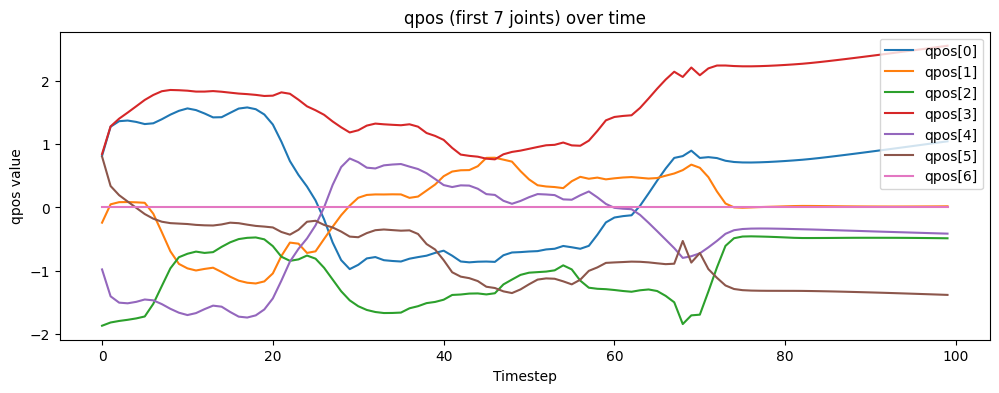

qvel shape: (100, 14)


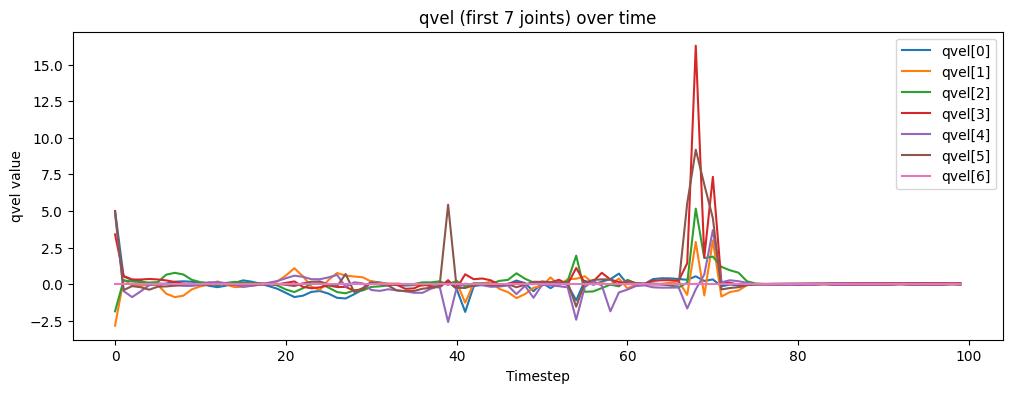

action shape: (100, 14)


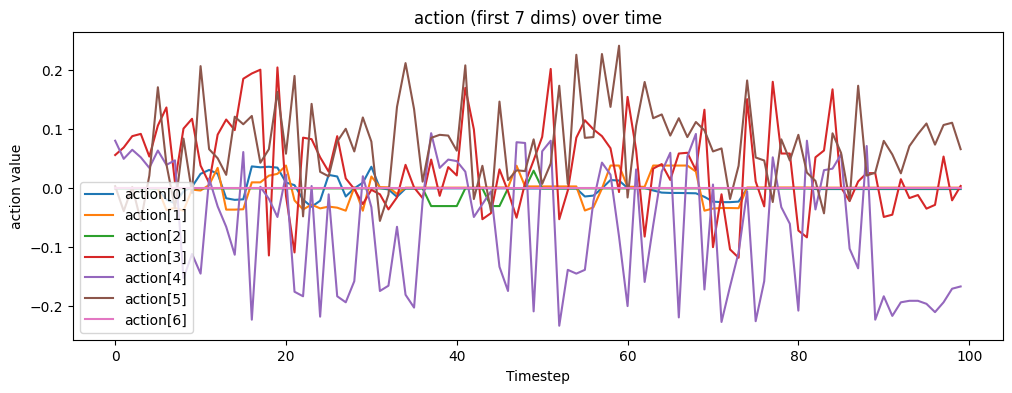

Image dataset 'overhead_cam' shape: (100, 480, 640, 3)


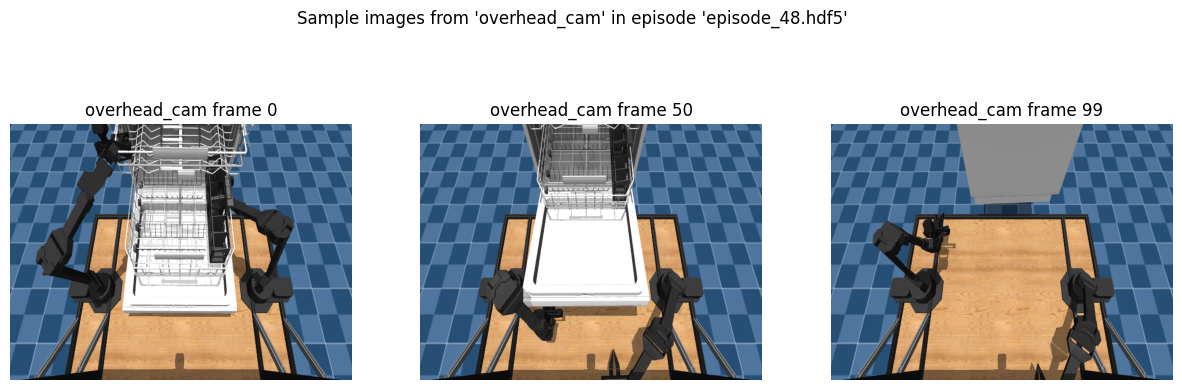

Image dataset 'teleoperator_pov' shape: (100, 480, 640, 3)


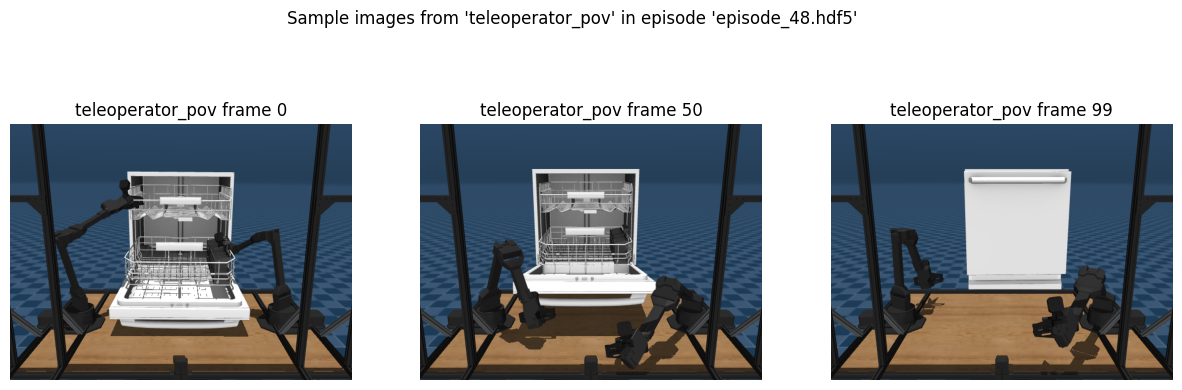

Image dataset 'wrist_cam_left' shape: (100, 480, 640, 3)


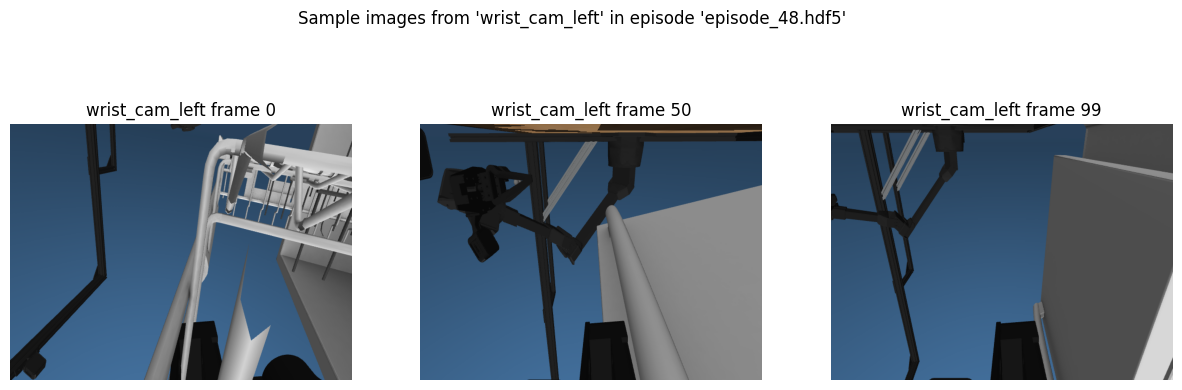

Image dataset 'wrist_cam_right' shape: (100, 480, 640, 3)


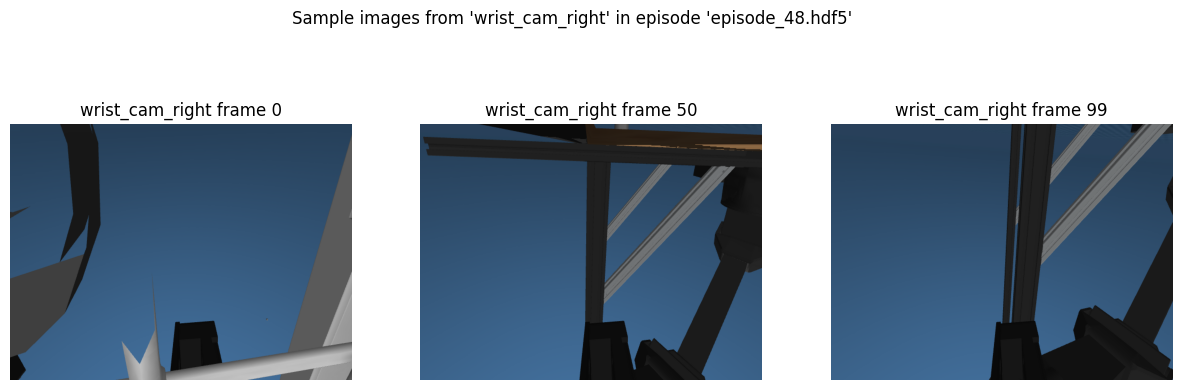

In [21]:
# Example usage:
review_episode_sample()  # random sample from ../data

# review_episode_sample(hdf5_name='episode_0.hdf5', data_folder='./my_data')